# HookedModelWrapper usage example

## Imports

In [1]:
from diffusion_deep_dream_research.modeling.hooked_model_wrapper import HookedModelWrapper
from diffusers import StableDiffusionPipeline
from submodules.SAeUron.SAE.sae import Sae
import torch
import matplotlib.pyplot as plt


Triton not installed, using eager implementation of SAE decoder.


/opt/homebrew/Caskroom/miniconda/base/envs/diffusion-deep-dream-research/lib/python3.12/site-packages/torch/amp/autocast_mode.py:270: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


## Device

In [2]:
# --- Setup Device ---
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    dtype = torch.float16
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    dtype = torch.float32
else:
    device = torch.device("cpu")
    dtype = torch.float32


In [3]:
print(device, dtype)

mps torch.float32


## Stable Diffusion Pipeline

In [4]:
model_path = "../assets/stable-diffusion-v1-4"

pipe = StableDiffusionPipeline.from_pretrained(model_path, torch_dtype=dtype)
pipe = pipe.to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


## SAE

In [5]:
sae = Sae.load_from_hub(
    name="bcywinski/SAeUron",
    hookpoint="unet.up_blocks.1.attentions.1",
    device=device
)

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

## Layer Wrapper

In [6]:
layer_wrapper = HookedModelWrapper.from_layer(
    pipe=pipe,
    target_layer_name="up_blocks.1.attentions.1"
)

## SAE Wrapper

In [7]:
sae_wrapper = HookedModelWrapper.from_sae(
    pipe=pipe,
    target_layer_name="up_blocks.1.attentions.1",
    sae=sae
)

## Forward with capture

### Layer

In [9]:
res=layer_wrapper.forward_with_capture(
    prompts=[
        "a dog in a style of van gogh"
    ],
    num_images_per_prompt=1
)

activations = res.hook_activations
images = res.images

  0%|          | 0/50 [00:00<?, ?it/s]

Captured activations at timesteps: [981, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741, 721, 701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461, 441, 421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181, 161, 141, 121, 101, 81, 61, 41, 21, 1]
Timestep 981: activation shape torch.Size([2, 1280])
Timestep 981: activation min -9.053449630737305, max 7.085991859436035
Timestep 961: activation shape torch.Size([2, 1280])
Timestep 961: activation min -9.229110717773438, max 7.10565710067749
Timestep 941: activation shape torch.Size([2, 1280])
Timestep 941: activation min -9.339202880859375, max 7.102627754211426
Timestep 921: activation shape torch.Size([2, 1280])
Timestep 921: activation min -9.385220527648926, max 7.0522050857543945
Timestep 901: activation shape torch.Size([2, 1280])
Timestep 901: activation min -9.249856948852539, max 6.946207046508789
Timestep 881: activation shape torch.Size([2, 1280])
Timestep 881: activation min -8.891855239868164

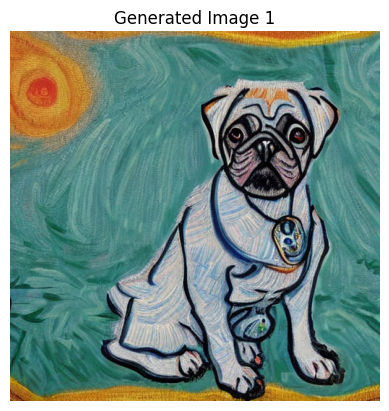

In [10]:
print(f"Captured activations at timesteps: {list(activations.keys())}")
for t, act in activations.items():
    print(f"Timestep {t}: activation shape {act.shape}")
    print(f"Timestep {t}: activation min {act.min()}, max {act.max()}")

for i, img in enumerate(images):
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Generated Image {i+1}")
    plt.show()

### SAE

In [11]:
res_2=sae_wrapper.forward_with_capture(
    prompts=[
        "a dog in a style of van gogh"
    ],
    num_images_per_prompt=1
)

activations_2 = res_2.hook_activations
images_2 = res_2.images

  0%|          | 0/50 [00:00<?, ?it/s]

Captured activations at timesteps: [981, 961, 941, 921, 901, 881, 861, 841, 821, 801, 781, 761, 741, 721, 701, 681, 661, 641, 621, 601, 581, 561, 541, 521, 501, 481, 461, 441, 421, 401, 381, 361, 341, 321, 301, 281, 261, 241, 221, 201, 181, 161, 141, 121, 101, 81, 61, 41, 21, 1]
Timestep 981: activation shape torch.Size([2, 20480])
Timestep 981: activation min 0.0, max 20.374399185180664
Timestep 961: activation shape torch.Size([2, 20480])
Timestep 961: activation min 0.0, max 20.072406768798828
Timestep 941: activation shape torch.Size([2, 20480])
Timestep 941: activation min 0.0, max 18.868579864501953
Timestep 921: activation shape torch.Size([2, 20480])
Timestep 921: activation min 0.0, max 16.110370635986328
Timestep 901: activation shape torch.Size([2, 20480])
Timestep 901: activation min 0.0, max 11.451803207397461
Timestep 881: activation shape torch.Size([2, 20480])
Timestep 881: activation min 0.0, max 13.624570846557617
Timestep 861: activation shape torch.Size([2, 20480])


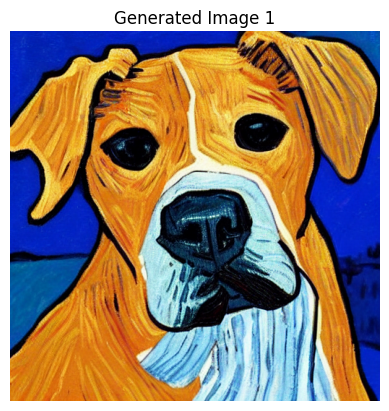

In [12]:
print(f"Captured activations at timesteps: {list(activations.keys())}")
for t, act in activations_2.items():
    print(f"Timestep {t}: activation shape {act.shape}")
    print(f"Timestep {t}: activation min {act.min()}, max {act.max()}")

for i, img in enumerate(images_2):
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Generated Image {i+1}")
    plt.show()

## Steering

### Layer

In [23]:
imgs = layer_wrapper.steer(
    channel=5,
    strength=50.0,
    timesteps=layer_wrapper.pipe_adapter.pipe.scheduler.timesteps.tolist(),
    output_type="pil",
    n_results=1,
    seeds=[1024]
)

  0%|          | 0/50 [00:00<?, ?it/s]

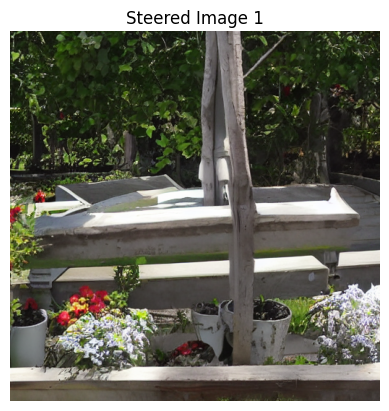

In [24]:
for i, img in enumerate(imgs):
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Steered Image {i+1}")
    plt.show()

### SAE

In [30]:
imgs_2 = sae_wrapper.steer(
    channel=19324,
    strength=100.0,
    timesteps=pipe.scheduler.timesteps.tolist(),
    output_type="pil",
    n_results=1,
    seeds=[1024]
)

  0%|          | 0/50 [00:00<?, ?it/s]

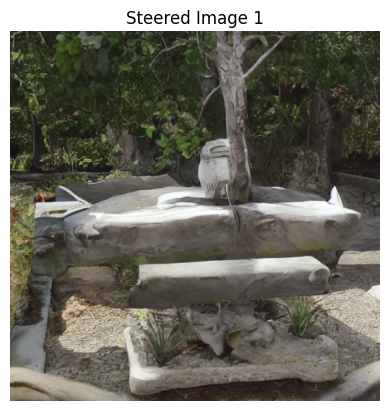

In [31]:
for i, img in enumerate(imgs_2):
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Steered Image {i+1}")
    plt.show()

## Activation (F)

### Layer

In [27]:
latent = torch.randn(1, 4, 64, 64).to(device)
latent_noise = layer_wrapper.apply_scheduler_noise(latent, timestep=0)
act = layer_wrapper.activation(
    z=latent_noise,
    channel=5,
    timestep=0
)

In [18]:
print(act.requires_grad)
print(act.shape)

True
torch.Size([])


### SAE

In [19]:
latent_2 = torch.randn(1, 4, 64, 64).to(device)
latent_2_noise = sae_wrapper.apply_scheduler_noise(latent_2, timestep=0)
act_2 = sae_wrapper.activation(
    z=latent_2_noise,
    channel=1500,
    timestep=0
)

In [20]:
print(act_2.requires_grad)
print(act_2.shape)

True
torch.Size([])


In [21]:
act

tensor(1.2773, device='mps:0', grad_fn=<MeanBackward0>)

In [22]:
act_2

tensor(0.0018, device='mps:0', grad_fn=<MeanBackward0>)

In [8]:
latents = sae_wrapper.steer(
    channel=19324,
    strength=100.0,
    timesteps=pipe.scheduler.timesteps.tolist(),
    output_type="latent",
    n_results=1,
    seeds=[1024]
)

  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
decoded_latents = sae_wrapper.decode_latents(latents)

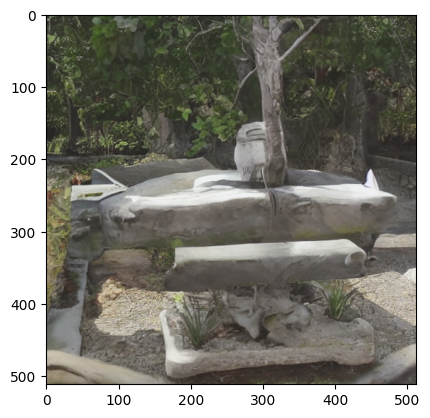

In [10]:
plt.imshow(decoded_latents[0])

In [11]:
noisy_latents = sae_wrapper.apply_scheduler_noise(
    latents, timestep=100
)

In [12]:
decoded_noisy_latents = sae_wrapper.decode_latents(
    noisy_latents
)

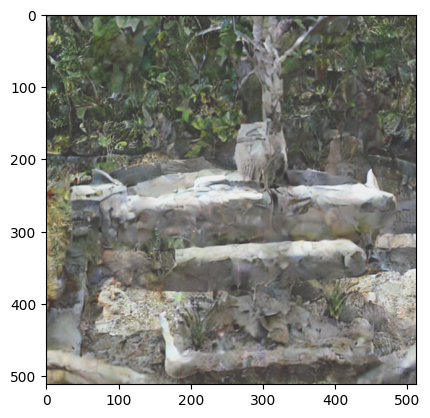

In [13]:
plt.imshow(decoded_noisy_latents[0])